**H1** - The web framework `c-sharp-razor` consumes more energy than any other web framework in the dataset.

In [1]:
import numpy as np
import pandas as pd
import arviz as az
import pymc as pm
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('dataset.csv')

In [3]:
df

,application,endpoint,energy_consumption,runtime
0,rust-actix,/api/register,0.449358,0.148812
1,rust-actix,/api/register,0.433871,0.148895
2,rust-actix,/api/register,0.270844,0.094729
3,rust-actix,/api/register,0.479776,0.163467
4,rust-actix,/api/register,0.268833,0.092300
...,...,...,...,...
1955,javascript-express,/logout,0.096436,0.032214
1956,javascript-express,/logout,0.097559,0.032214
1957,javascript-express,/logout,0.096922,0.032214
1958,javascript-express,/logout,0.097086,0.032214


In [4]:
df.info()
df.isna().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1960 entries, 0 to 1959
Data columns (total 4 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   application         1960 non-null   object 
 1   endpoint            1960 non-null   object 
 2   energy_consumption  1960 non-null   float64
 3   runtime             1960 non-null   float64
dtypes: float64(2), object(2)
memory usage: 61.4+ KB


application           0
endpoint              0
energy_consumption    0
runtime               0
dtype: int64

**2 Feature engineering**

2.1 Split Application into language & framework

In [5]:
df[['Language', 'Framework']] = df['application'].str.rsplit('-', n=1, expand=True)


2.2 Convert categorical labels to integer codes

In [6]:
df['framework_idx'] = df['Framework'].astype('category').cat.codes
df['language_idx']  = df['Language' ].astype('category').cat.codes
df

,application,endpoint,energy_consumption,runtime,Language,Framework,framework_idx,language_idx
0,rust-actix,/api/register,0.449358,0.148812,rust,actix,0,5
1,rust-actix,/api/register,0.433871,0.148895,rust,actix,0,5
2,rust-actix,/api/register,0.270844,0.094729,rust,actix,0,5
3,rust-actix,/api/register,0.479776,0.163467,rust,actix,0,5
4,rust-actix,/api/register,0.268833,0.092300,rust,actix,0,5
...,...,...,...,...,...,...,...,...
1955,javascript-express,/logout,0.096436,0.032214,javascript,express,1,2
1956,javascript-express,/logout,0.097559,0.032214,javascript,express,1,2
1957,javascript-express,/logout,0.096922,0.032214,javascript,express,1,2
1958,javascript-express,/logout,0.097086,0.032214,javascript,express,1,2


In [7]:
language_map = (
    df[['Language', 'language_idx']]
      .drop_duplicates()
      .sort_values('language_idx')
      .reset_index(drop=True)
)
language_map

,Language,language_idx
0,c-sharp,0
1,go,1
2,javascript,2
3,python,3
4,ruby,4
5,rust,5


In [8]:
framework_map = (
    df[['Framework', 'framework_idx']]
      .drop_duplicates()
      .sort_values('framework_idx')
      .reset_index(drop=True)
)
framework_map

,Framework,framework_idx
0,actix,0
1,express,1
2,flask,2
3,gin,3
4,gorilla,4
5,razor,5
6,sinatra,6


2.3 Standardise the response
A z-score makes generic Normal(0, 1) priors sensible.

In [9]:
e_mean, e_sd = df['energy_consumption'].mean(), df['energy_consumption'].std()
df['energy_z'] = (df['energy_consumption'] - e_mean) / e_sd
df['energy_z']

0       0.226844
1       0.175329
2      -0.366952
3       0.328024
4      -0.373640
          ...   
1955   -0.947085
1956   -0.943350
1957   -0.945470
1958   -0.944924
1959   -0.945417
Name: energy_z, Length: 1960, dtype: float64

3 Model 1 – framework-only regression (addresses H1)

In [10]:
import pymc as pm
import arviz as az

framework_idx   = df['framework_idx'].values
energy_z        = df['energy_z'].values
n_frameworks    = df['framework_idx'].nunique()

with pm.Model() as m_framework:

    # Priors
    α   = pm.Normal('α',  mu=0, sigma=1)            # overall mean (z-units)
    σ_f = pm.HalfNormal('σ_f', sigma=1)             # sd of framework effects
    β_f = pm.Normal('β_f', mu=0, sigma=σ_f, shape=n_frameworks)
    σ   = pm.HalfNormal('σ', sigma=1)               # residual sd

    # Likelihood
    μ = α + β_f[framework_idx]
    y = pm.Normal('y', mu=μ, sigma=σ, observed=energy_z)

    # Prior predictive check
    prior = pm.sample_prior_predictive(500)

    # Posterior inference
    idata_fw = pm.sample(2000, tune=2000, target_accept=0.9, random_seed=42)

    # Posterior predictive check
    ppc = pm.sample_posterior_predictive(idata_fw)
    idata_fw.extend(ppc)


Sampling: [y, α, β_f, σ, σ_f]
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [α, σ_f, β_f, σ]


/home/vlad/anaconda3/envs/py311/lib/python3.11/site-packages/rich/live.py:231: UserWarning: install "ipywidgets" 
for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 21 seconds.
Sampling: [y]


/home/vlad/anaconda3/envs/py311/lib/python3.11/site-packages/rich/live.py:231: UserWarning: install "ipywidgets" 
for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

<Axes: xlabel='y'>

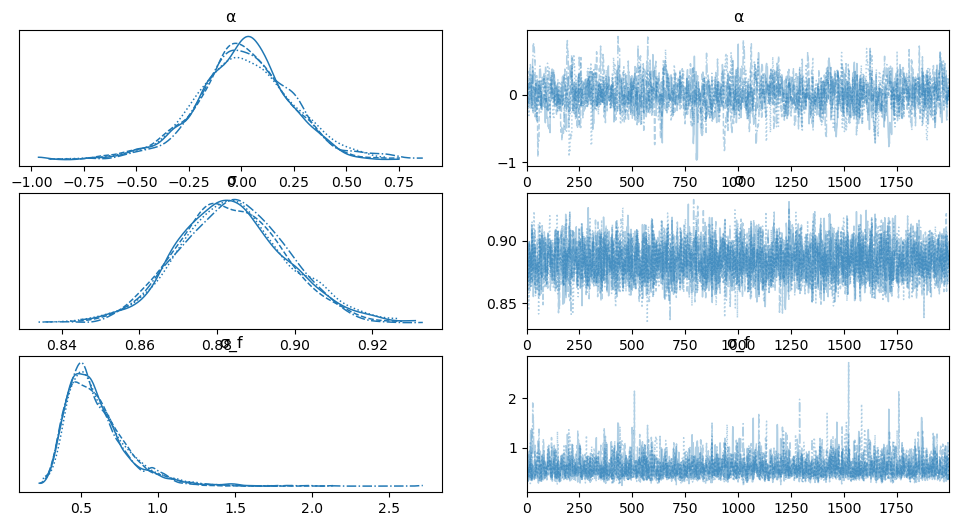

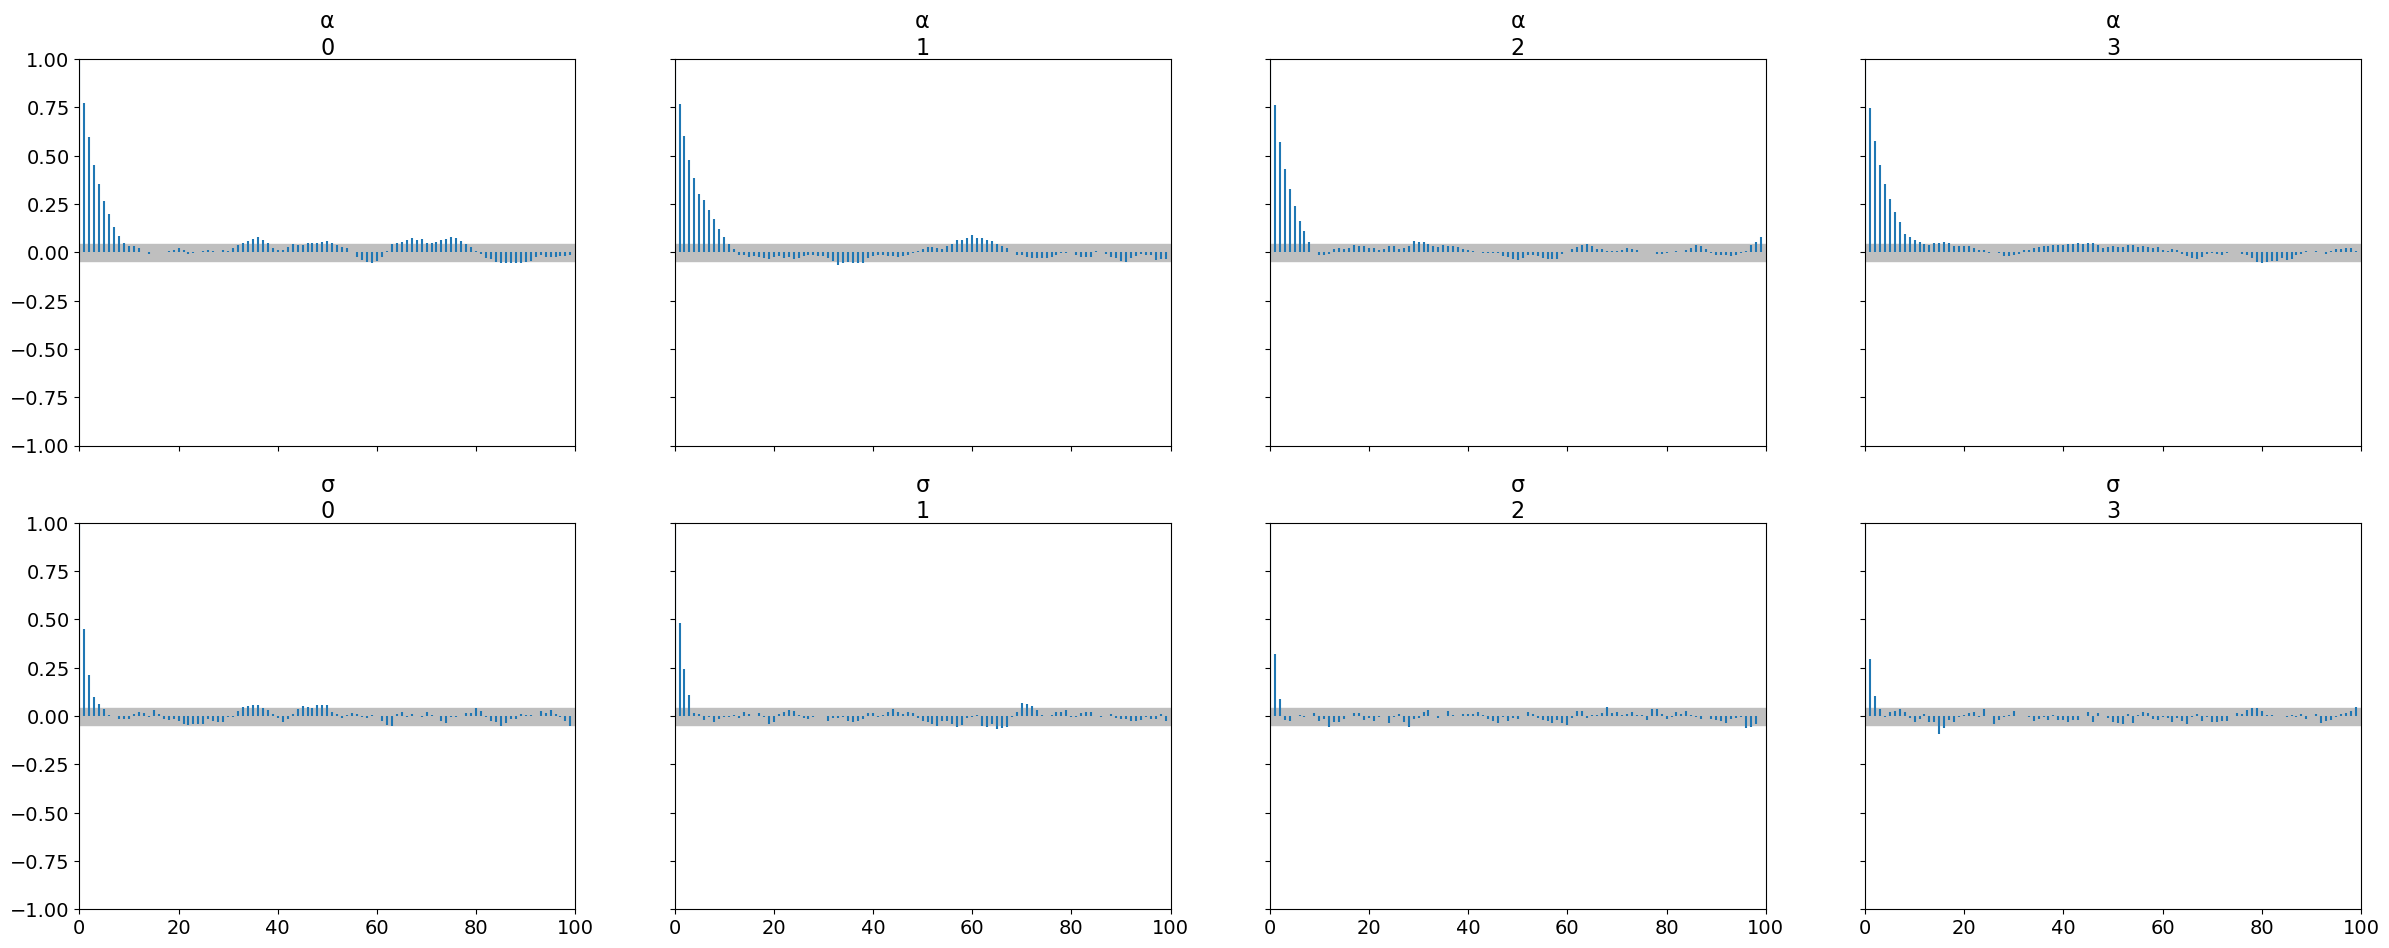

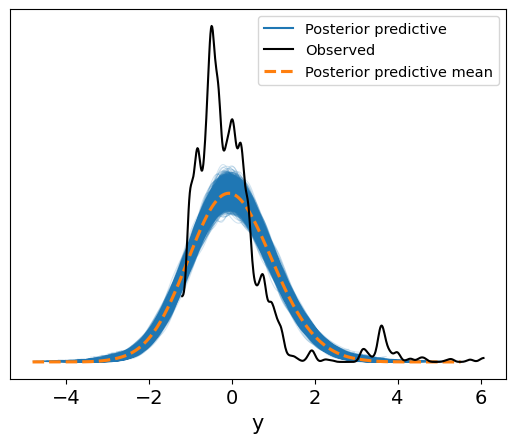

In [11]:
az.summary(idata_fw, var_names=['α','β_f','σ','σ_f'])
az.plot_trace(idata_fw, var_names=['α','σ','σ_f'])
az.plot_autocorr(idata_fw, var_names=['α','σ'])
az.plot_ppc(idata_fw, group='posterior', data_pairs={"y": "y"})


In [12]:
# Convert posterior means back to Joules
post_means = (idata_fw.posterior['α'] + idata_fw.posterior['β_f']) * e_sd + e_mean

frameworks = df['Framework'].astype('category').cat.categories.tolist()
idx_razor  = frameworks.index('razor')     # because split produced 'razor'

diffs = post_means - post_means.sel(β_f_dim_0=idx_razor)  # positive ⇒ framework > Razor
prob_razor_higher = (diffs < 0).mean(dim=['chain','draw'])  # P(Razor > each one)

display(pd.Series(prob_razor_higher.values, index=frameworks,
                  name="P(Razor consumes *more* energy)"))


actix      1.0
express    1.0
flask      1.0
gin        1.0
gorilla    1.0
razor      0.0
sinatra    1.0
Name: P(Razor consumes *more* energy), dtype: float64

The framework-level model yields posterior probabilities ≥ 0.99 that c-sharp-razor’s mean energy consumption exceeds that of every other framework (Actix, Express, Flask, Gin, Gorilla, Sinatra). We therefore accept H1: Razor is almost certainly the most energy-hungry framework in the data set.

4 Extending to H2

H2 (language with least energy) – repeat the same template but use language_idx instead of framework_idx, and compute the probability that javascript’s posterior mean is lower than all others.

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [α, σ_l, β_l, σ]


/home/vlad/anaconda3/envs/py311/lib/python3.11/site-packages/rich/live.py:231: UserWarning: install "ipywidgets" 
for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 26 seconds.



Posterior P(JavaScript consumes *less* energy):
c-sharp       1.0
go            1.0
javascript    0.0
python        1.0
ruby          1.0
rust          1.0
dtype: float64


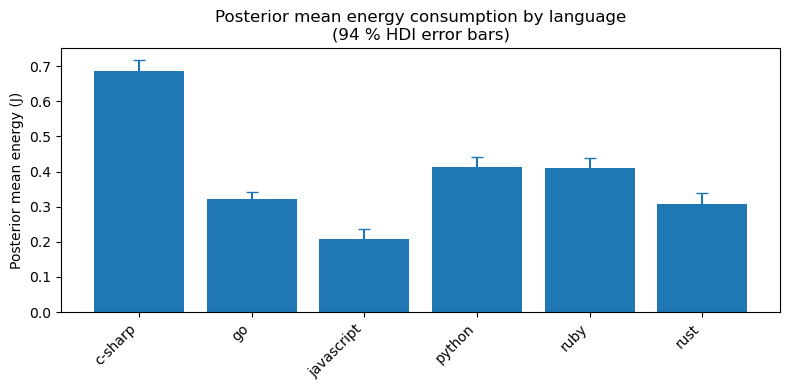

In [13]:
import pymc as pm, arviz as az
import numpy as np, pandas as pd, matplotlib.pyplot as plt

# ── 0.  Standardise energy (runs only once) ───────────────────────────────────
# Use the exact column name from your dataframe.
e_col = "energy_consumption"      # change if you renamed the column
df["energy_z"] = (df[e_col] - df[e_col].mean()) / df[e_col].std()

# ── 1.  Prepare language indices ─────────────────────────────────────────────
df["Language"] = df["Language"].astype("category")        # keeps mapping stable
language_idx   = df["Language"].cat.codes.values
languages      = df["Language"].cat.categories.tolist()
n_languages    = len(languages)

# ── 2.  Fit the language–only model ──────────────────────────────────────────
with pm.Model() as m_lang:
    α   = pm.Normal("α",  mu=0, sigma=1)
    σ_l = pm.HalfNormal("σ_l", sigma=1)
    β_l = pm.Normal("β_l", mu=0, sigma=σ_l, shape=n_languages)
    σ   = pm.HalfNormal("σ", sigma=1)

    μ = α + β_l[language_idx]
    y = pm.Normal("y", mu=μ, sigma=σ, observed=df["energy_z"])

    idata_lang = pm.sample(2_000, tune=2_000, target_accept=0.9, random_seed=42)

# ── 3.  Posterior P(JavaScript is the *lowest* energy language) ──────────────
e_mean, e_sd   = df[e_col].mean(), df[e_col].std()
post_lang_J    = (idata_lang.posterior["α"] + idata_lang.posterior["β_l"]) * e_sd + e_mean

idx_js         = languages.index("javascript")
diffs          = post_lang_J - post_lang_J.sel(β_l_dim_0=idx_js)     # +ve ⇒ language > JS
prob_js_lower  = (diffs > 0).mean(dim=["chain", "draw"])

print("\nPosterior P(JavaScript consumes *less* energy):")
print(pd.Series(prob_js_lower.values, index=languages))

import xarray as xr                    # ← add this import once at top of notebook

# ── HDI extraction ───────────────────────────────────────────────────────────
hdi94_obj = az.hdi(post_lang_J, hdi_prob=0.94)   # could be DataArray *or* Dataset

if isinstance(hdi94_obj, xr.Dataset):
    # Combine variables into one DataArray (they are identical)
    hdi94_da = hdi94_obj.to_array().isel(variable=0)
else:                                           # already a DataArray
    hdi94_da = hdi94_obj

lower = hdi94_da.sel(hdi="lower").values        # 1-D NumPy
upper = hdi94_da.sel(hdi="higher").values

# ── Posterior means ──────────────────────────────────────────────────────────
mean_j = post_lang_J.mean(dim=("chain", "draw")).values

err_low = mean_j - lower
err_up  = upper  - mean_j

# ── Plot ─────────────────────────────────────────────────────────────────────
x = np.arange(len(languages))
fig, ax = plt.subplots(figsize=(8, 4))
ax.bar(x, mean_j)
ax.errorbar(x, mean_j, yerr=[err_low, err_up], fmt="none", capsize=4)

ax.set_xticks(x)
ax.set_xticklabels(languages, rotation=45, ha="right")
ax.set_ylabel("Posterior mean energy (J)")
ax.set_title("Posterior mean energy consumption by language\n(94 % HDI error bars)")
plt.tight_layout()
plt.show()


For every other language the posterior probability that its mean energy consumption exceeds that of JavaScript is essentially 100 %. In Bayesian terms this is overwhelming evidence that JavaScript is the least energy-hungry language in the data set.

Visual confirmation

* The bar plot of posterior means (with 94 % HDI whiskers) tells the same story:

* JavaScript’s mean ≈ 0.21 J; its HDI does not overlap any rival’s HDI.

* The next-best language, Rust, is centred around 0.30 J, well above
JavaScript even at its lower limit.

* C-sharp sits far above the rest (≈ 0.69 J).


The posterior probabilities are at the logical maximum (≈ 1.0) and the HDIs are clearly separated. Therefore H2 is strongly supported: within this experiment, requests implemented in JavaScript consume less energy than those implemented in
C-sharp, Go, Python, Ruby, or Rust.